# 1. Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, BatchNormalization, Activation, ZeroPadding2D, LeakyReLU, ReLU, UpSampling2D, Conv2D, Conv2DTranspose
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

# 2. Load Data

In [2]:
df_original = pd.read_csv('emnist-letters-train.csv', header=None)
df_original

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,23,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,16,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,15,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,23,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99035,18,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
99036,24,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
99037,19,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
99038,-1,174,174,174,174,174,174,174,174,174,...,174,174,174,174,174,174,174,174,174,174


From the dataframe shown above, we can see that there are 785 different columns and 99040 different rows. After some analysis of the data in excel, we hypothesized that column 0 is the label column which identifies what alphabet the image would represent in its number-letter correspondence (with -1 representing a blank image) and the rest of the columns are pixel values. Hence for each row, we have 1 label value and 784 pixel values which can be nicely reshaped into a 28x28 image

To confirm our hypothesis, we will do some data analysis of the dataset

# 3. Exploratory Data Aanalysis

Get all the labels in the dataset

In [3]:
alphabets = df_original.iloc[:, 0]
alphabets

0        23
1         7
2        16
3        15
4        23
         ..
99035    18
99036    24
99037    19
99038    -1
99039    -1
Name: 0, Length: 99040, dtype: int64

Get all the pixel values in the dataset

In [4]:
df = df_original.iloc[:, 1:]
df

,1,2,3,4,5,6,7,8,9,10,...,775,776,777,778,779,780,781,782,783,784
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99035,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
99036,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
99037,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
99038,174,174,174,174,174,174,174,174,174,174,...,174,174,174,174,174,174,174,174,174,174


## y-label Analysis

As we all know, there are 26 different alphabets in the English language. Hence we should have 26 different labels in the dataset if our hypothesis is correct

In [5]:
np.sort(alphabets.unique())

array([-1,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26], dtype=int64)

In [6]:
len(alphabets.unique())

27

However, we can see that there are actually 27 different unique labels in the dataset with the values ranging from 1 to 26 and -1. Let's try to find out what -1 represents and whether labels 1-26 are the alphabets' number-letter correspondence by plotting them out as images

Before that, we need to do some data preprocessing to be able to plot out our images. As we can see from the datasets above, every row contains pixel values for every image in the form of a 1D array in as there are 784 columns which can be reshaped into a 28x28 array. We need to reshape them into 2D arrays to visualize them

## Pixel Values

In [7]:
print(f'Highest pixel value: {df.max().max()}')
print(f'Lowest pixel value: {df.min().min()}')

Highest pixel value: 255
Lowest pixel value: 0


The pixel values of the dataset ranges from 0 to 255 which confirms our hypothesis that the columns 1-785 are pixel values

## Data Preprocessing

In [8]:
def createMatrix(df):
    """
    Gets the pixel value from each row and reshapes it into a 28x28 matrix
    """
    arr = []

    for row in range(len(df)):
        img = df.iloc[row, :].values.reshape((28, 28))
        arr.append(img)

    arr = np.array(arr)
    print(arr.shape)

    return arr

In [9]:
imageArr = createMatrix(df)

(99040, 28, 28)


## Plot Images

Using plt.imshow(), we can visualise our transformed 2D arrays as grayscale images

In [10]:
def imageSubplot(arr, numberOfImages, titles=None):
    """
    Plots a 3 by `numberOfImages` grid of images
    """
    plt.figure()

    for i in range(numberOfImages):
        plt.subplot(numberOfImages // 3, 3, i+1)  
        plt.imshow(arr[i], cmap='gray')
        plt.axis('off')
        if titles:
            plt.title(titles[i])
        else:
            plt.title(f'Image {i+1}')

    plt.tight_layout()  
    plt.show()

### -1 Labelled Image

Locate the indexes for the images labelled -1

In [11]:
df_original[df_original.iloc[:, 0] == -1].index

Index([   20,    30,    31,    36,    39,    41,    56,    65,    74,    75,
       ...
       98979, 99003, 99007, 99010, 99012, 99020, 99023, 99034, 99038, 99039],
      dtype='int64', length=10240)

In [12]:
blankArr = [imageArr[20], imageArr[30], imageArr[31]]

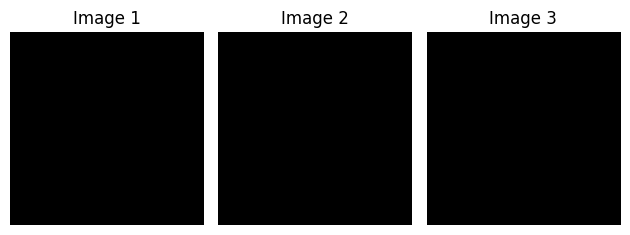

In [13]:
imageSubplot(blankArr, len(blankArr))

From the image plots above, we can see that the images labelled -1 are blank images. Hence we can conclude that -1 represents a blank image

### Alphabet Images

Plot out first 6 images of the dataset

In [14]:
first6labels = df_original.iloc[:6, 0].values
first6alphabets = list(map(lambda x: f'{x}: {chr(x + 96)}', first6labels))

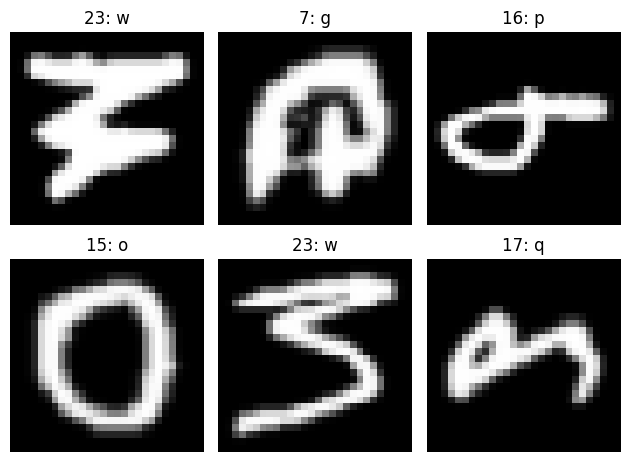

In [15]:
imageSubplot(imageArr, 6, first6alphabets)  # convert from number to alphabet and display them as subplot titles

From the images above, we can see that the images labelled 1-26 are the number-letter correspondence of the English alphabets. Hence we can conclude that the labels 1-26 are the alphabets' number-letter correspondence

However, we can see that our alphabets look slightly off. This is because the images are not in the correct orientation. We need to transpose them to the correct orientation (rotate 90 degrees clockwise + flip horizontally). We will do that by updating our createMatrix() function

## Image Transformation

In [165]:
def createMatrix(df):
    """
    Gets the pixel value from each row and reshapes it into a 28x28 matrix and transposes it
    """
    arr = []

    for row in range(len(df)):
        img = df.iloc[row, :].values.reshape((28, 28))
        arr.append(np.transpose(img))

    arr = np.array(arr)
    print(arr.shape)

    return arr

In [166]:
imageArr = createMatrix(df)

(99040, 28, 28)


Now let's visualise the transformed images and verify that they are in the correct orientation

### Blank Images

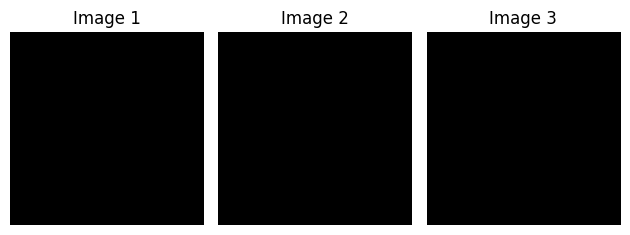

In [167]:
imageSubplot(blankArr, len(blankArr))

### Alphabet Images

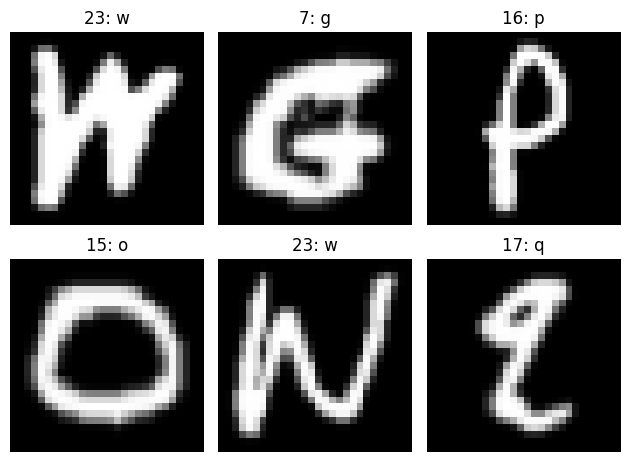

In [170]:
imageSubplot(imageArr, 6, first6alphabets)

We have successfully verified that our transformation works and the images are now in the correct orientation. Our hypothesis about the first column being the labels and the rest of the columns being pixel values has been confirmed

As our task is to generate images of the alphabets which do not include blank images, we should only focus on the images labelled 1-26 and ignore the blank images labelled -1

## Image Distribution

In [172]:
labels, counts = np.unique(alphabets, return_counts=True)
totalBlankImages = counts[np.where(labels == -1)]
totalAlphabetImages = np.sum(counts[np.where(labels != -1)])

In [191]:
numberOfImages = {}
for label, count in zip(labels, counts):
    numberOfImages[label] = count
numberOfImages

{-1: 10240,
 1: 3396,
 2: 3396,
 3: 3419,
 4: 3398,
 5: 3437,
 6: 3394,
 7: 3385,
 8: 3424,
 9: 3428,
 10: 3402,
 11: 3438,
 12: 3415,
 13: 3402,
 14: 3365,
 15: 3408,
 16: 3430,
 17: 3435,
 18: 3419,
 19: 3392,
 20: 3436,
 21: 3419,
 22: 3422,
 23: 3423,
 24: 3437,
 25: 3453,
 26: 3427}

<Axes: xlabel='0', ylabel='count'>

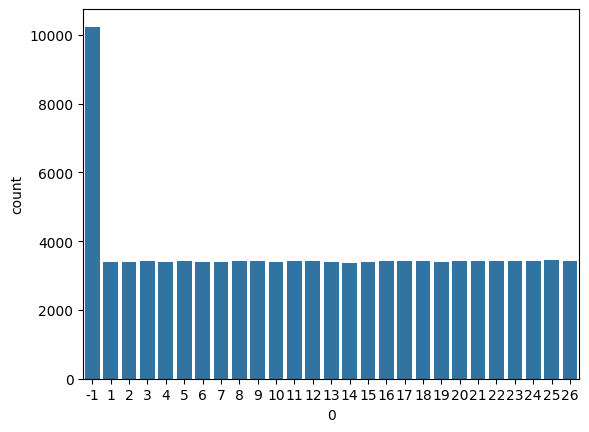

In [173]:
sns.countplot(x=alphabets)

In [176]:
print(f'Average difference between blank and alphabet images: {(totalBlankImages - (totalAlphabetImages / len(counts)))[0]}')

Average difference between blank and alphabet images: 6951.111111111111


We can see that there is a huge difference (~7000 images) in the number of blank images compared to each the number of images for each alphabet. However, if we put into perspective the total number of alphabet images and the total number of blank images, will the difference still be significant?

In [179]:
print(f'Percentage: {round((totalBlankImages / totalAlphabetImages * 100)[0], 2)}%')

Percentage: 11.53%


Since the total number of blank images is just above 10% of the whole dataset, we can safely ignore the blank images and focus on the alphabet images since generating alphabet images is our main task

## Alphabet Image Distribution

In [192]:
numberOfAlphabetImages = numberOfImages  # make a copy of the dictionary
numberOfAlphabetImages.pop(-1)  # remove the blank image counts
numberOfAlphabetImages

{1: 3396,
 2: 3396,
 3: 3419,
 4: 3398,
 5: 3437,
 6: 3394,
 7: 3385,
 8: 3424,
 9: 3428,
 10: 3402,
 11: 3438,
 12: 3415,
 13: 3402,
 14: 3365,
 15: 3408,
 16: 3430,
 17: 3435,
 18: 3419,
 19: 3392,
 20: 3436,
 21: 3419,
 22: 3422,
 23: 3423,
 24: 3437,
 25: 3453,
 26: 3427}

<Axes: xlabel='0', ylabel='count'>

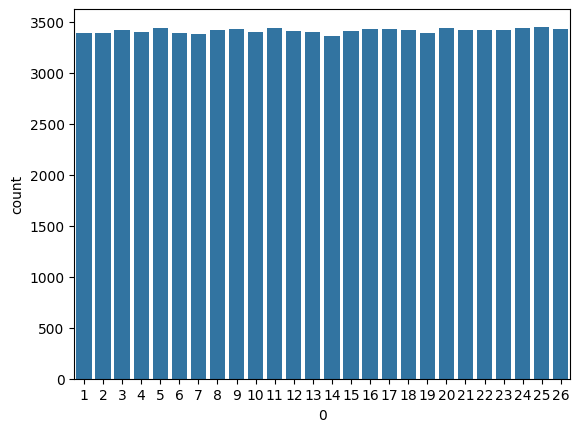

In [ ]:
sns.countplot(x=alphabets[alphabets != -1])

### Alphabet 'a'

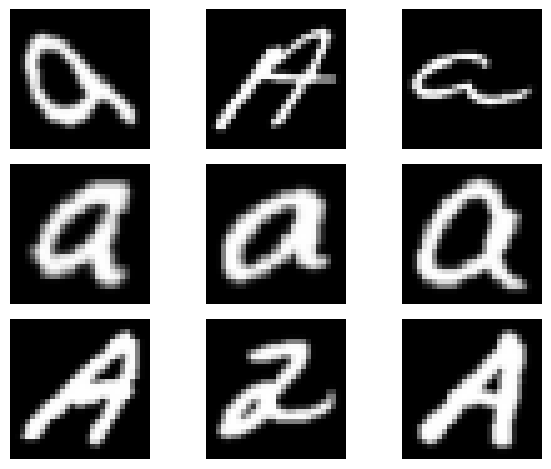

In [ ]:
imageSubplot(aArr, 9)

## Excluding Images Without Alphabets

In [61]:
df_without_blank = df_original[df_original.iloc[:, 0] != -1].drop(0, axis=1)
df_without_blank

,1,2,3,4,5,6,7,8,9,10,...,775,776,777,778,779,780,781,782,783,784
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99032,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
99033,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
99035,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
99036,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [65]:
withoutBlankArr = createMatrix(df_without_blank)

(88800, 28, 28)


In [74]:
withoutBlankArr = createMatrix(df_without_blank)

(88800, 28, 28)


# Model Training (With -1)

## Conv2DTranpose from Lab 5

In [ ]:
class DCGAN():
    
    # this is the function to build the generator neural network
    def build_generator(self):
        model = Sequential(name='Generator')
        model.add(Dense(128 * 7 * 7, activation="relu", input_dim=self.latent_dim)) # connect the input to dense layer
        model.add(Reshape((7, 7, 128)))
        # upsample from 7*7 to 14*14
        model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        # upsample to 28x28
        model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Conv2D(self.channels, kernel_size=7, padding="same", activation='sigmoid'))
        model.summary()
        noise = Input(shape=(self.latent_dim,))
        img = model(noise)
        return Model(noise, img)  # the keras Model class groups layers into an object with training and inference features
    
    def build_discriminator(self):
        model = Sequential(name='Discriminator')
        model.add(Conv2D(128, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))
        model.summary()
        img = Input(shape=self.img_shape)
        validity = model(img)
        return Model(img, validity)

    def __init__(self, rows, cols, channels, z = 100):
        # Input shape
        self.img_rows = rows  # generated image height
        self.img_cols = cols  # generated image width
        self.channels = channels  # generated image channel
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = z  # the input is 1-D vector of noise
        # Reduce learning rate from 0.001 to 0.0002, and beta1 from 0.9 to 0.5, which can stablize training and reduce oscillation
        optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])
        # Build the generator
        self.generator = self.build_generator()
        # The generator takes noise as input and generates images
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)
        # For the combined model we will only train the generator
        self.discriminator.trainable = False
        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(img)
        # The combined model (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy',
            optimizer=optimizer)
    
    def train(self, epochs, batch_size=128, save_interval=50):
        # Load the dataset
        X_train = np.array(imageArr)
        # Rescale 0 to 1
        X_train = X_train / 255
        X_train = np.expand_dims(X_train, axis=3)
        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        for epoch in range(epochs):
            # ---------------------
            # Train Discriminator
            # ---------------------
            # Select a random half of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]
            # Sample noise and generate a batch of new images
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise)
            # Train the discriminator (it classify real images as 1 and generated images as 0)
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            # Train the generator (it wants discriminator to predict generated images as 1)
            g_loss = self.combined.train_on_batch(noise, valid)
            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
            
            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.save_imgs(epoch)
    
    def save_imgs(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        # gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        os.makedirs('generated_mnist', exist_ok=True)
        fig.savefig("generated_mnist/dcgan_mnist_{:d}.png".format(epoch))
        plt.close()

In [ ]:
dcgan = DCGAN(28,28,1)
dcgan.train(epochs=5000, batch_size=256, save_interval=50)

## Upsampling from Lab 5

In [ ]:
class DCGAN():
    def __init__(self, rows, cols, channels, z = 10):
        # Input shape
        self.img_rows = rows
        self.img_cols = cols
        self.channels = channels
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = z

        optimizer = Adam(0.0001, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def build_generator(self):

        model = Sequential()

        model.add(Dense(128 * 7 * 7, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((7, 7, 128)))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(Conv2D(self.channels, kernel_size=3, padding="same"))
        model.add(Activation("tanh"))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))

        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=256, save_interval=50):

        # Load the dataset
        X_train = np.array(imageArr)

        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.
        X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            # Sample noise and generate a batch of new images
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator (real classified as ones and generated as zeros)
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Train the generator (wants discriminator to mistake images as real)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.save_imgs(epoch)

    def save_imgs(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("dcgan_mnist_{:d}.png".format(epoch))
        plt.close()


In [ ]:
dcgan = DCGAN(28,28,1)
dcgan.train(epochs=5000, batch_size=256, save_interval=50)

## Editted Conv2DTranspose 

In [ ]:
class DCGAN():
    
    # this is the function to build the generator neural network
    def build_generator(self):
        model = Sequential(name='Generator')
        model.add(Dense(256 * 7 * 7, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((7, 7, 256)))
        model.add(BatchNormalization())

        model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization())

        model.add(Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization())

        model.add(Conv2D(self.channels, kernel_size=7, padding="same", activation='sigmoid'))
        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)
        return Model(noise, img)
        
    def build_discriminator(self):
        model = Sequential(name='Discriminator')

        model.add(Conv2D(64, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))  # Adjust dropout rate

        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))  # Adjust dropout rate

        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)
        return Model(img, validity)

    def __init__(self, rows, cols, channels, z = 100):
        # Input shape
        self.img_rows = rows  # generated image height
        self.img_cols = cols  # generated image width
        self.channels = channels  # generated image channel
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = z  # the input is 1-D vector of noise
        # Reduce learning rate from 0.001 to 0.0002, and beta1 from 0.9 to 0.5, which can stablize training and reduce oscillation
        optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])
        # Build the generator
        self.generator = self.build_generator()
        # The generator takes noise as input and generates images
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)
        # For the combined model we will only train the generator
        self.discriminator.trainable = False
        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(img)
        # The combined model (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy',
            optimizer=optimizer)
    
    def train(self, epochs, batch_size=128, save_interval=50):
        # Load the dataset
        X_train = np.array(imageArr)
        # Rescale 0 to 1
        X_train = X_train / 255
        X_train = np.expand_dims(X_train, axis=3)
        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        for epoch in range(epochs):
            # ---------------------
            # Train Discriminator
            # ---------------------
            # Select a random half of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]
            # Sample noise and generate a batch of new images
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise)
            # Train the discriminator (it classify real images as 1 and generated images as 0)
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            # Train the generator (it wants discriminator to predict generated images as 1)
            g_loss = self.combined.train_on_batch(noise, valid)
            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
            
            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.save_imgs(epoch)
    
    def save_imgs(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        # gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        os.makedirs('generated_mnist', exist_ok=True)
        fig.savefig("generated_mnist/dcgan_mnist_{:d}.png".format(epoch))
        plt.close()

# Model Training (Without -1)

## machinelearningmastery

In [44]:
class DCGAN:
    def __init__(self, rows, cols, channels, z=100):
        # Input shape
        self.img_rows = rows  # generated image height
        self.img_cols = cols  # generated image width
        self.channels = channels  # generated image channel
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = z  # the input is 1-D vector of noise
        # Reduce learning rate from 0.001 to 0.0002, and beta1 from 0.9 to 0.5, which can stabilize training and reduce oscillation
        disc_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
        gen_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
                                   optimizer=disc_optimizer,
                                   metrics=['accuracy'])
        # Build the generator
        self.generator = self.build_generator()
        # The generator takes noise as input and generates images
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)
        # For the combined model we will only train the generator
        self.discriminator.trainable = False
        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(img)
        # The combined model (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy',
                              optimizer=gen_optimizer)

    def build_generator(self):
        model = Sequential(name='Generator')
        model.add(Dense(256 * 7 * 7, activation="relu", input_dim=self.latent_dim)) # connect the input to dense layer
        model.add(BatchNormalization())
        model.add(ReLU())
        model.add(Reshape((7, 7, 256)))
        # upsample from 7*7 to 14*14
        model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
        model.add(BatchNormalization())
        model.add(ReLU())
        # upsample to 28x28
        model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
        model.add(BatchNormalization())
        model.add(ReLU())
        model.add(Conv2D(self.channels, (3,3), padding="same", activation='tanh'))
        model.summary()
        noise = Input(shape=(self.latent_dim,))
        img = model(noise)
        return Model(noise, img)  # the keras Model class groups layers into an object with training and inference features
    
    def build_discriminator(self):
        model = Sequential(name='Discriminator')
        # normal
        model.add(Conv2D(128, (3,3), padding='same', input_shape=self.img_shape))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        # downsample
        model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
        model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        # classifier
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))
        model.summary()
        img = Input(shape=self.img_shape)
        validity = model(img)
        return Model(img, validity)

    def train(self, epochs, batch_size=128, save_interval=50):
        # scale to [-1, 1]
        X_train = withoutBlankArr / 127.5 - 1
        X_train = np.expand_dims(X_train, axis=3)
        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        # Lists to store the losses
        d_losses = []
        g_losses = []

        for epoch in range(epochs):
            # ---------------------
            # Train Discriminator
            # ---------------------
            # Select a random half of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]
            # Sample noise and generate a batch of new images
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise)
            # Train the discriminator (it classify real images as 1 and generated images as 0)
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            d_losses.append(d_loss[0])  # Record the discriminator loss

            # ---------------------
            # Train Generator
            # ---------------------
            # Train the generator (it wants discriminator to predict generated images as 1)
            g_loss = self.combined.train_on_batch(noise, valid)
            g_losses.append(g_loss)  # Record the generator loss

            # Plot the progress
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100 * d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.save_imgs(epoch)

        # Plot loss curves
        self.plot_loss(d_losses, g_losses)

    def save_imgs(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        # gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
                axs[i, j].axis('off')
                cnt += 1
        os.makedirs('generated_mnist', exist_ok=True)
        fig.savefig("generated_mnist/dcgan_mnist_{:d}.png".format(epoch))
        plt.close()

    def plot_loss(self, d_losses, g_losses):
        plt.figure(figsize=(10, 5))
        plt.plot(d_losses, label='Discriminator Loss')
        plt.plot(g_losses, label='Generator Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Loss Curves')
        plt.legend()
        plt.show()

In [ ]:
dcgan = DCGAN(28,28,1)
dcgan.train(epochs=5000, batch_size=256, save_interval=50)

## test

In [26]:
import numpy as np
from tensorflow.keras.layers import Dense, BatchNormalization, ReLU, Reshape, Conv2DTranspose, Conv2D, LeakyReLU, Dropout, Flatten, Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
import matplotlib.pyplot as plt
import os
from scipy.linalg import sqrtm
import tensorflow as tf

class DCGAN:
    def __init__(self, rows, cols, channels, z=100):
        # Input shape
        self.img_rows = rows
        self.img_cols = cols
        self.channels = channels
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = z
        disc_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
        gen_optimizer = Adam(learning_rate=0.0001, beta_1=0.5)
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
                                   optimizer=disc_optimizer,
                                   metrics=['accuracy'])
        self.generator = self.build_generator()
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)
        self.discriminator.trainable = False
        valid = self.discriminator(img)
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy',
                              optimizer=gen_optimizer)

    def build_generator(self):
        model = Sequential(name='Generator')
        model.add(Dense(7*7*256, use_bias=False, input_dim=self.latent_dim))
        model.add(BatchNormalization())
        model.add(ReLU())
        model.add(Reshape((7, 7, 256)))

        model.add(Conv2DTranspose(128, (1, 1), strides=(2, 2), padding='same', use_bias=False))
        model.add(BatchNormalization())
        model.add(ReLU())

        model.add(Conv2DTranspose(128, (3, 3), strides=(1, 1), padding='same', use_bias=False))
        model.add(BatchNormalization())
        model.add(ReLU())

        model.add(Conv2DTranspose(128, (3, 3), strides=(1, 1), padding='same', use_bias=False))
        model.add(BatchNormalization())
        model.add(ReLU())

        model.add(Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
        model.add(BatchNormalization())
        model.add(ReLU())

        model.add(Conv2DTranspose(1, (3, 3), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))
        model.summary()
        noise = Input(shape=(self.latent_dim,))
        img = model(noise)
        return Model(noise, img)

    def build_discriminator(self):
        model = Sequential(name='Discriminator')
        model.add(Conv2D(64, kernel_size=3, strides=5, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))

        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))

        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        
        model.add(Dense(1, activation='sigmoid'))
        model.summary()
        img = Input(shape=self.img_shape)
        validity = model(img)
        return Model(img, validity)

    def preprocess_for_inception(self, images):
        images_rgb = []
        for img in images:
            # Convert grayscale to RGB by repeating the single channel three times
            img_rgb = np.repeat(img, 3, axis=-1)
            img_resized = tf.image.resize(img_rgb, (299, 299))
            img_resized = img_to_array(img_resized)
            images_rgb.append(img_resized)
        images_rgb = np.array(images_rgb)
        return preprocess_input(images_rgb)

    def calculate_fid(self, model, real_images, generated_images):
        # Resize images to (299, 299) and convert grayscale to RGB
        real_images_resized = self.preprocess_for_inception(real_images)
        generated_images_resized = self.preprocess_for_inception(generated_images)
        # Get the activations from the InceptionV3 model
        act_real = model.predict(real_images_resized)
        act_gen = model.predict(generated_images_resized)
        # Calculate the mean and covariance of the activations
        mu_real, sigma_real = act_real.mean(axis=0), np.cov(act_real, rowvar=False)
        mu_gen, sigma_gen = act_gen.mean(axis=0), np.cov(act_gen, rowvar=False)
        # Calculate the sum of squared differences between means
        ssdiff = np.sum((mu_real - mu_gen) ** 2.0)
        # Calculate the square root of the product of the covariances
        covmean = sqrtm(sigma_real.dot(sigma_gen))
        # Handle imaginary numbers
        if np.iscomplexobj(covmean):
            covmean = covmean.real
        # Calculate the FID score
        fid = ssdiff + np.trace(sigma_real + sigma_gen - 2.0 * covmean)
        return fid

    def train(self, epochs, batch_size=128, save_interval=50):
        inception_model = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))

        # scale to [-1, 1]
        X_train = (withoutBlankArr - 127.5) / 127.5
        X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        # Lists to store the losses and FID scores
        d_losses = []
        g_losses = []
        fid_scores = []

        for epoch in range(epochs):
            # ---------------------
            # Train Discriminator
            # ---------------------
            # Select a random half of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]
            # Sample noise and generate a batch of new images
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise)
            # Train the discriminator (it classify real images as 1 and generated images as 0)
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            d_losses.append(d_loss[0])  # Record the discriminator loss

            # ---------------------
            # Train Generator
            # ---------------------
            # Train the generator (it wants discriminator to predict generated images as 1)
            g_loss = self.combined.train_on_batch(noise, valid)
            g_losses.append(g_loss)  # Record the generator loss

            # Calculate FID score at intervals
            if epoch % save_interval == 0:
                fid = self.calculate_fid(inception_model, imgs, gen_imgs)
                fid_scores.append(fid)
                print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100 * d_loss[1]:.2f}%] [G loss: {g_loss}] [FID: {fid}]")
                self.save_imgs(epoch)

        # Plot loss curves and FID scores
        self.plot_loss(d_losses, g_losses, fid_scores)

    def save_imgs(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
                axs[i, j].axis('off')
                cnt += 1
        if not os.path.exists('images'):
            os.makedirs('images')
        fig.savefig(f"images/mnist_{epoch}.png")
        plt.close()

    def plot_loss(self, d_losses, g_losses, fid_scores):
        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.plot(d_losses, label="Discriminator loss")
        plt.plot(g_losses, label="Generator loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot([i*50 for i in range(len(fid_scores))], fid_scores, label="FID score")
        plt.xlabel("Epoch")
        plt.ylabel("FID score")
        plt.legend()

        if not os.path.exists('plots'):
            os.makedirs('plots')
        plt.savefig("plots/loss_fid.png")
        plt.show()

# Ensure your training dataset withoutBlankArr is properly loaded here

dcgan = DCGAN(28, 28, 1)
dcgan.train(epochs=10001, batch_size=256, save_interval=50)

Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_388 (Conv2D)         (None, 6, 6, 64)          640       
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 6, 6, 64)          0         
                                                                 
 dropout_12 (Dropout)        (None, 6, 6, 64)          0         
                                                                 
 conv2d_389 (Conv2D)         (None, 3, 3, 128)         73856     
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 3, 3, 128)         0         
                                                                 
 dropout_13 (Dropout)        (None, 3, 3, 128)         0         
                                                                 
 conv2d_390 (Conv2D)         (None, 2, 2, 128)       

KeyboardInterrupt: 